In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# 1. 데이터 로드
# =========================
df = pd.read_csv("machine_failure.csv")  # 파일명 수정 가능

df.rename(columns={
    'Air temperature [K]': 'Air_temp_K',
    'Process temperature [K]': 'Process_temp_K',
    'Rotational speed [rpm]': 'Rotational_speed_rpm',
    'Torque [Nm]': 'Torque_Nm',
    'Tool wear [min]': 'Tool_wear_min'
}, inplace=True)

# =========================
# 2. 입력(X) / 타깃(y) 분리
# =========================
X = df[
    [
        "Type",
        "Air_temp_K",
        "Process_temp_K",
        "Rotational_speed_rpm",
        "Torque_Nm",
        "Tool_wear_min"
    ]
]

y = df["Machine failure"]

# =========================
# 3. train / test 분리
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# =========================
# 4. 전처리 파이프라인
# =========================
numeric_features = [
    "Air_temp_K",
    "Process_temp_K",
    "Rotational_speed_rpm",
    "Torque_Nm",
    "Tool_wear_min"
]

categorical_features = ["Type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# =========================
# 5. 모델 정의
# =========================
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# =========================
# 6. 전체 파이프라인
# =========================
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ]
)

# =========================
# 7. 모델 학습
# =========================
pipeline.fit(X_train, y_train)

# =========================
# 8. 평가
# =========================
y_pred = pipeline.predict(X_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred))


Confusion Matrix
[[1929    3]
 [  39   29]]

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.91      0.43      0.58        68

    accuracy                           0.98      2000
   macro avg       0.94      0.71      0.78      2000
weighted avg       0.98      0.98      0.98      2000



In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 1. 데이터 로드 (파일 경로를 실제 경로로 수정하세요)
df = pd.read_csv('machine_failure.csv')

df.rename(columns={
    'Air temperature [K]': 'Air_temp_K',
    'Process temperature [K]': 'Process_temp_K',
    'Rotational speed [rpm]': 'Rotational_speed_rpm',
    'Torque [Nm]': 'Torque_Nm',
    'Tool wear [min]': 'Tool_wear_min'
}, inplace=True)

# 2. 전처리: 불필요한 식별자 및 2단계 전용 레이블 제거
# 1단계에서는 오직 'Machine failure'만 타겟으로 사용합니다.
features = ['Type', 'Air_temp_K', 'Process_temp_K', 
            'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min']
X = df[features].copy()
y = df['Machine failure']

# 범주형 데이터 'Type' 인코딩 (L, M, H)
X['Type'] = X['Type'].map({'L': 0, 'M': 1, 'H': 2})

# 3. 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. 모델 생성 및 학습
# scale_pos_weight: 고장 데이터(1)가 적으므로 가중치를 주어 불균형을 해소합니다.
model_stage1 = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)

print("1단계 모델 학습 시작 (고장 유무 판별)...")

model_stage1.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50), # 50번 동안 개선 없으면 멈춤
        log_evaluation(period=10)           # 10번째마다 로그 출력
    ]
)

# 5. 모델 평가
y_pred = model_stage1.predict(X_test)
print("\n[Confusion Matrix]")
print(confusion_matrix(y_test, y_pred))
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, model_stage1.predict_proba(X_test)[:, 1]):.4f}")


probabilities = model_stage1.predict_proba(X_test)

# 고장(1)일 확률만 추출 (두 번째 컬럼)
failure_probabilities = probabilities[:, 1] 

# 특정 데이터 하나에 대한 확률 (예: 85.4%)
single_prob = round(failure_probabilities[0] * 100, 2)

print(single_prob)
# # 6. 모델 저장 (2단계에서 활용하기 위함)
# import joblib
# joblib.dump(model_stage1, 'stage1_failure_predictor.pkl')

1단계 모델 학습 시작 (고장 유무 판별)...
[LightGBM] [Info] Number of positive: 271, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350616
[LightGBM] [Info] Start training from score -3.350616
Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.956845	valid_0's binary_logloss: 0.0849732
[20]	valid_0's auc: 0.958212	valid_0's binary_logloss: 0.0805384
[30]	valid_0's auc: 0.975445	valid_0's binary_logloss: 0.0779784
[40]	valid_0's auc: 0.976818	valid_0's binary_logloss: 0.0772392
[50]	valid_0's auc: 0.979342	valid_0's binary_logloss: 0.0737851
[60]	valid_0's auc: 0.978025	valid_0's binary_logloss: 0.0734437
[70]	valid_0's auc: 0.979197	valid

In [83]:
import pandas as pd
import numpy as np

# 1. 테스트용 가상 데이터 생성 (정상 vs 고장 의심)
# 컬럼명은 반드시 학습할 때 사용했던 이름과 동일해야 합니다!
test_data = pd.DataFrame([
    {
        'Type': 1, # M
        'Air_temperature': 300.1, 
        'Process_temperature': 310.2, 
        'Rotational_speed': 1500, 
        'Torque': 40.5, 
        'Tool_wear': 5
    }, # 케이스 1: 정상적인 수치
    {
        'Type': 0, # L
        'Air_temperature': 305.5, 
        'Process_temperature': 315.0, 
        'Rotational_speed': 20, # 매우 높은 회전수
        'Torque': 70.2,            # 매우 높은 토크
        'Tool_wear': 220           # 공구 마모도가 한계치에 도달
    },  # 케이스 2: 고장 가능성이 높은 수치
    {
        'Type': 1, # L
        'Air_temperature': 295,   # 
        'Process_temperature': 310, 
        'Rotational_speed': 1350, # 매우 높은 회전수
        'Torque': 25.2,            # 매우 높은 토크
        'Tool_wear': 255         # 공구 마모도가 한계치에 도달
    }  # 케이스 2: 고장 가능성이 높은 수치
])

# 2. 예측 수행
# (1) 고장 유무 판별 (0 또는 1)
predictions = model_stage1.predict(test_data)

# (2) 고장 확률 계산 (프론트에 전달할 확률값)
probabilities = model_stage1.predict_proba(test_data)[:, 1]

# 3. 결과 출력
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    status = "⚠️ 고장 위험" if pred == 1 else "✅ 정상"
    print(f"[데이터 {i+1}] 예측 결과: {status} (확률: {prob*100:.2f}%)")

[데이터 1] 예측 결과: ✅ 정상 (확률: 0.08%)
[데이터 2] 예측 결과: ⚠️ 고장 위험 (확률: 99.07%)
[데이터 3] 예측 결과: ✅ 정상 (확률: 10.56%)


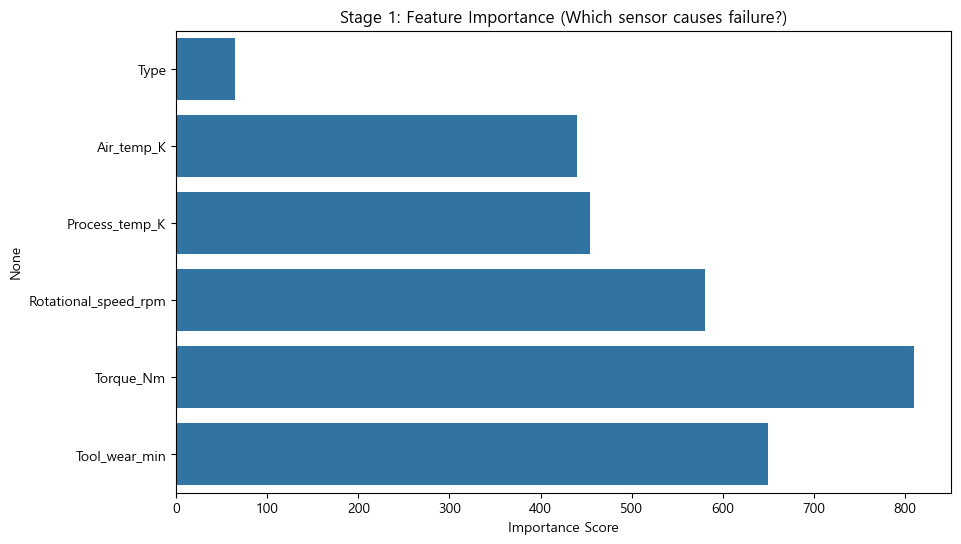

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델의 피처 중요도 추출
importances = model_stage1.feature_importances_
feature_names = X.columns

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Stage 1: Feature Importance (Which sensor causes failure?)')
plt.xlabel('Importance Score')
plt.show()

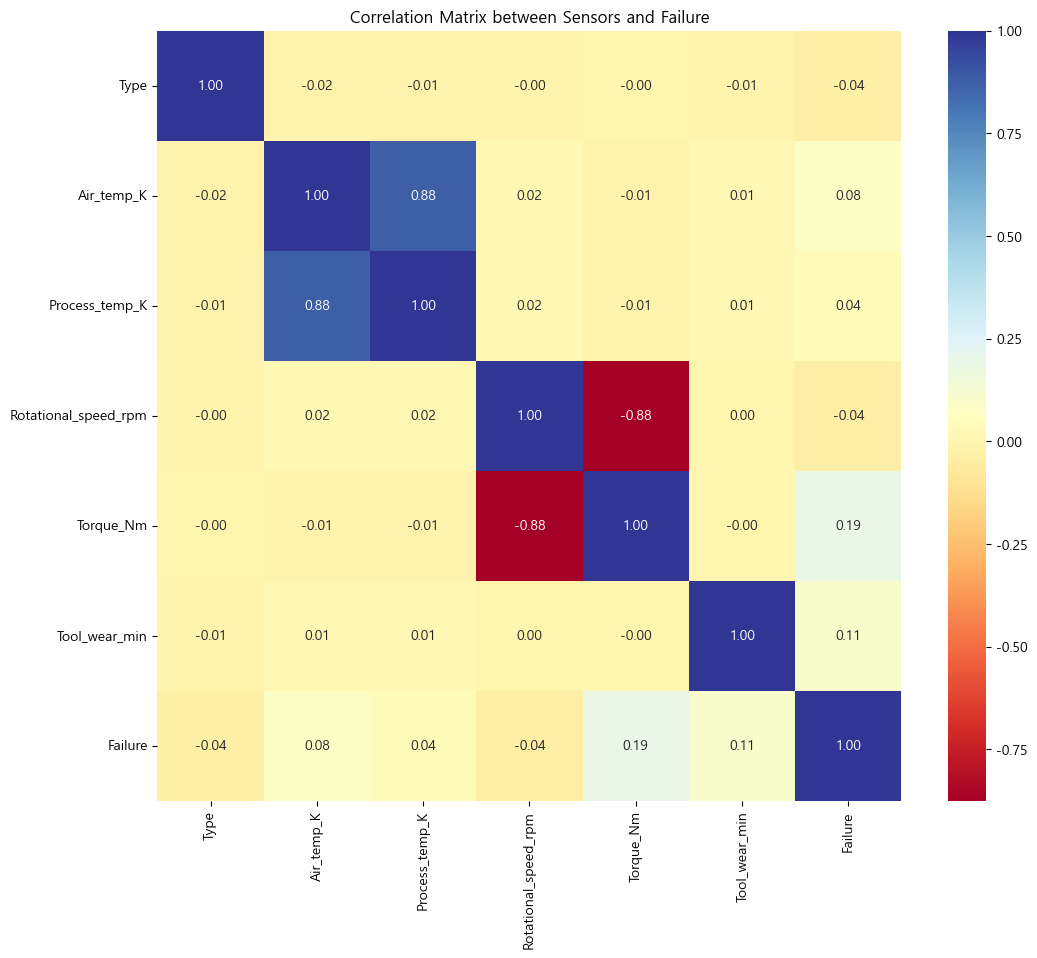

In [78]:
# 상관관계 계산을 위해 타겟 변수를 포함한 임시 데이터프레임 생성
corr_df = X.copy()
corr_df['Failure'] = y

# 상관계수 산출
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df.corr(), annot=True, cmap='RdYlBu', fmt='.2f')
plt.title('Correlation Matrix between Sensors and Failure')
plt.show()